In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode

import bambi
import pymc3 as pm
import arviz as az

from seaborn import despine
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

from utils.plotting import cm2inch, violin
from utils.descriptives import aggregate_subject_level_data
from utils.stats import get_var
from utils.general import make_sure_path_exists

# Data I/O

In [2]:
setsizes = np.array([9, 16, 25, 36])
n_setsizes = setsizes.size

subjects = np.arange(49)
n_subjects = subjects.size

# indicators for set sizes
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']
markers = ['o', '^', 's', 'D']

In [3]:
model_names = ['probabilistic_satisficing', 'independent_accumulation', 'GLAM']
gaze_bias_states = ['with_active_gaze', 'with_passive_gaze']

In [4]:
mfx_dir = 'results/posterior_traces/mixed_effects_models/'
# make sure output dir exists
for model_name in model_names:
    for gaze_bias in gaze_bias_states:
        make_sure_path_exists('results/predictions/{}_{}/'.format(model_name, gaze_bias))
        make_sure_path_exists('results/posterior_traces/{}_{}/'.format(model_name, gaze_bias))
        make_sure_path_exists('results/waic/{}_{}/'.format(model_name, gaze_bias))

### Test convergence of individual models

In [5]:
for setsize in setsizes:
    for subject in subjects:
        for model_name in model_names:
            for gaze_bias in gaze_bias_states:
                filepath = 'results/posterior_traces/{}_{}/{}_{}_mtrace_summary.csv'.format(
                        model_name, gaze_bias, subject, setsize)
                if os.path.isfile(filepath):
                    trace_summary = pd.read_csv(filepath)
                    
                    enough_eff = np.all(trace_summary['ess_mean'].values > 100)
                    good_gelman = np.all([np.abs(R-1) < 0.05 for R in trace_summary['r_hat'].values if not np.isnan(R)])

                    if not enough_eff or not good_gelman:
                        print('{}_{}: not converged for subject {} in set size {}'.format(model_name, gaze_bias, subject, setsize))
                        
                else:
                    print('/!\ no trace summary for {}_{} subject {} in set size {}'.format(
                        model_name, gaze_bias, subject, setsize))
                if not os.path.isfile('results/posterior_traces/{}_{}/{}_{}_mtrace.csv'.format(
                        model_name, gaze_bias, subject, setsize)):
                    print('/!\ no trace data for {}_{} subject {} in set size {}'.format(
                        model_name, gaze_bias, subject, setsize))
                    

independent_accumulation_with_active_gaze: not converged for subject 12 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 39 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 42 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 12 in set size 16
independent_accumulation_with_active_gaze: not converged for subject 17 in set size 25
independent_accumulation_with_passive_gaze: not converged for subject 22 in set size 25
independent_accumulation_with_active_gaze: not converged for subject 17 in set size 36


# Create Figure 5: Relative Fit

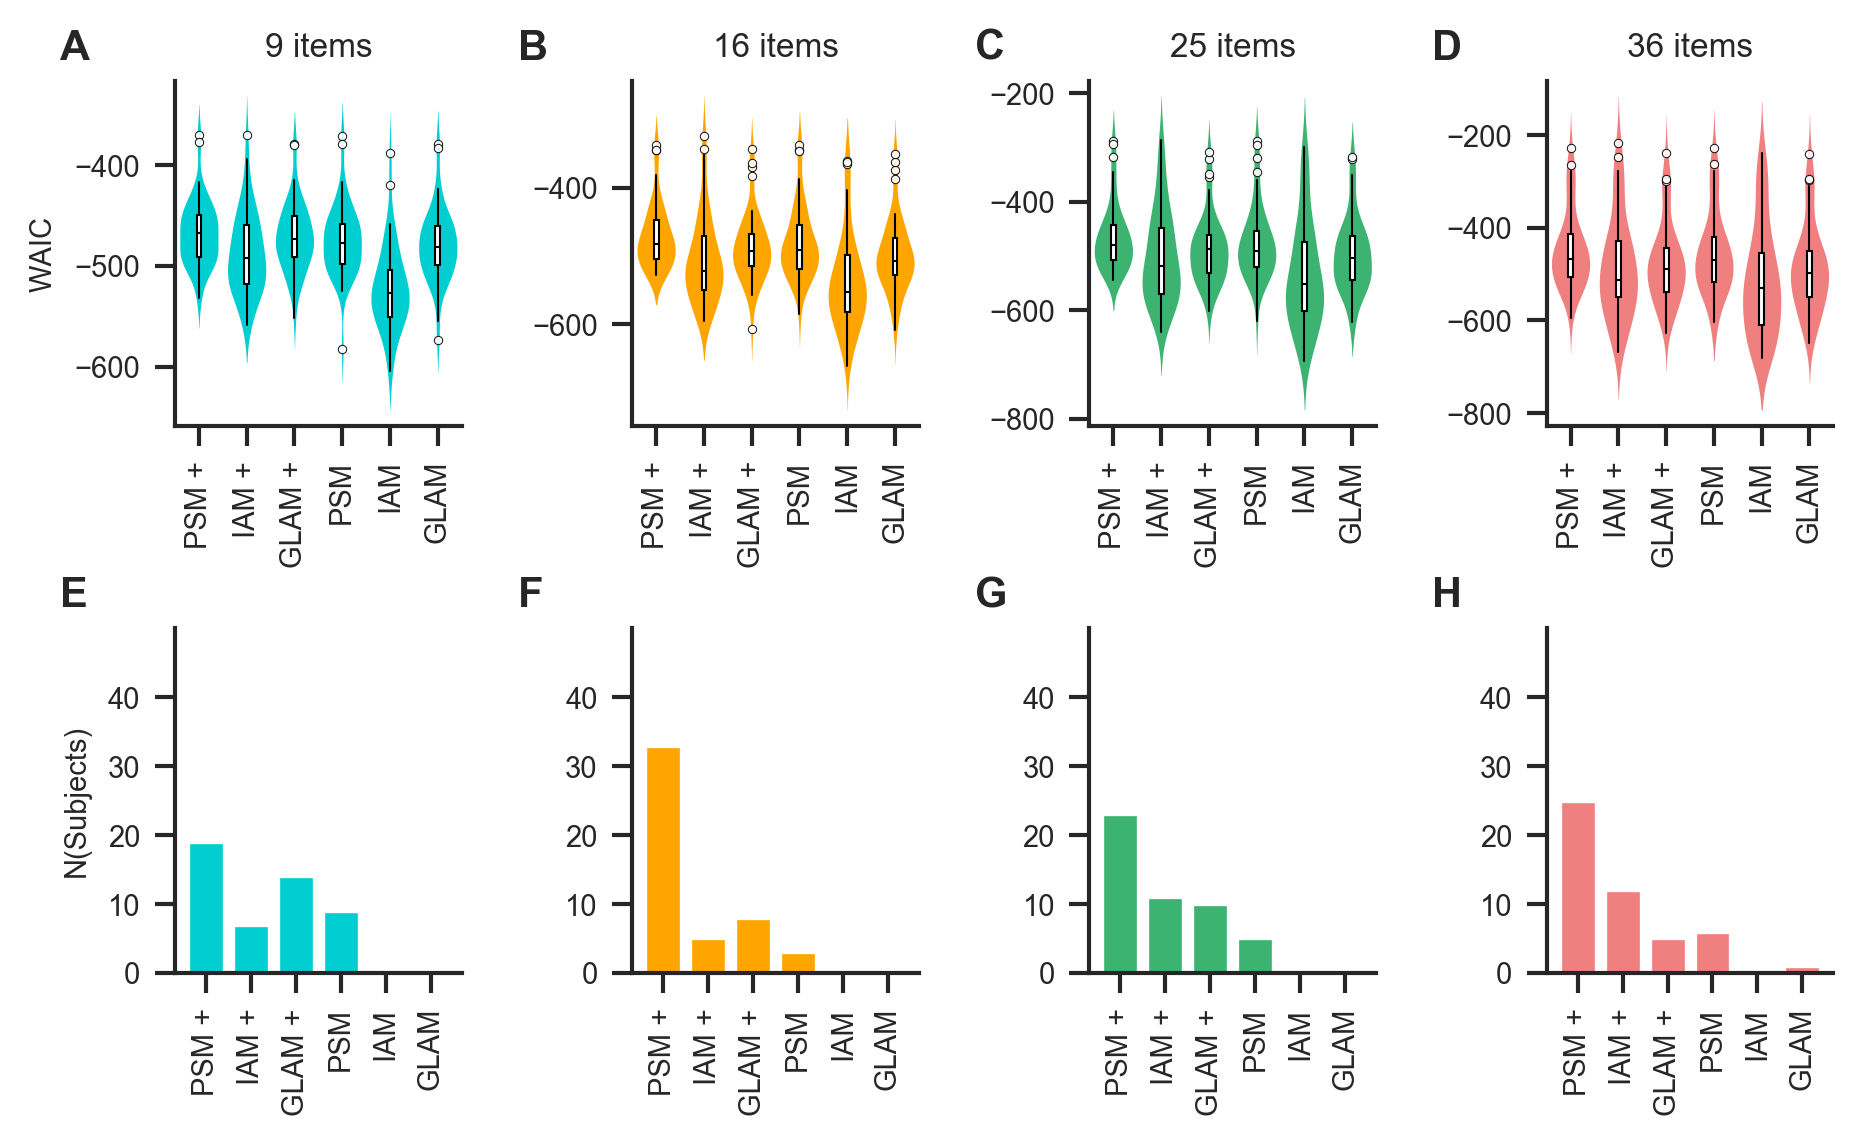

In [6]:
fig, axs = plt.subplots(2,4,figsize=cm2inch(16,10), dpi=300)

WAIC = np.zeros((setsizes.size, subjects.size, len(model_names)*len(gaze_bias_states))) * np.nan
for si, setsize in enumerate(setsizes):
    for subject in subjects:
        mi = 0
        for gaze_bias in gaze_bias_states:
            for model_name in model_names:
                filepath = 'results/waic/{}_{}/{}_{}_waic.csv'.format(model_name, gaze_bias, subject, setsize)
                if os.path.isfile(filepath):
                    waic = pd.read_csv(filepath)
                    WAIC[si,subject,mi] = waic['WAIC'].values[0]
                else:
                    WAIC[si,subject,mi] = np.nan
                mi += 1
        
    # plot violin
    axs[0,si] = violin(data=pd.DataFrame(WAIC[si]), ax=axs[0,si], palette=[colors[si]]*WAIC.shape[-1])
    axs[0,si].set_title('{} items'.format(setsize), fontsize=8)
    axs[0,si].set_xticks(np.arange(6))
    axs[0,si].set_xticklabels(['PSM +', 'IAM +', 'GLAM +', 'PSM', 'IAM', 'GLAM'], fontsize=7, rotation=90)
    axs[0,si].tick_params(labelsize=7)
    axs[0,si].set_xlabel('', fontsize=7)
    if si == 0:
        axs[0,si].set_ylabel('WAIC', fontsize=7)
    else:
        axs[0,si].set_ylabel('', fontsize=7)
    
    # plot N best described
    for mi in np.arange(6):
        axs[1,si].bar(mi, np.sum(np.argmax(WAIC[si], axis=-1)==mi), color=colors[si])
    axs[1,si].set_xticks(np.arange(6))
    axs[1,si].set_xticklabels(['PSM +', 'IAM +', 'GLAM +', 'PSM', 'IAM', 'GLAM'], fontsize=7, rotation=90)
    axs[1,si].tick_params(labelsize=7)
    if si == 0:
        axs[1,si].set_ylabel('N(Subjects)', fontsize=7)
    else:
        axs[1,si].set_ylabel('', fontsize=7)
    axs[1,si].set_ylim(0,50)
    axs[1,si].set_yticks([0, 10, 20, 30, 40])

for label, ax in zip(list('ABCDEFGH'), axs.ravel()):
    despine(ax=ax)
    ax.text(-0.4, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')

fig.tight_layout(h_pad=0)
fig.savefig('figures/Figure-5_relative-fit.pdf',dpi=300)
fig.savefig('figures/Figure-5_relative-fit.jpg',dpi=300)
fig.savefig('figures/Figure-5_relative-fit.png',dpi=300)

In [7]:
for si, setsize in enumerate(setsizes):
    print('\nSet size: {}'.format(setsize))
    mi = 0
    for gaze_bias in gaze_bias_states:
        for model_name in model_names:
            print('{} ({:1.2f}%)best described by: {}_{}'.format(
                np.sum(np.argmax(WAIC[si], axis=1)==mi),
                np.sum(np.argmax(WAIC[si], axis=1)==mi)/49. * 100,
                model_name, gaze_bias))
            mi += 1


Set size: 9
19 (38.78%)best described by: probabilistic_satisficing_with_active_gaze
7 (14.29%)best described by: independent_accumulation_with_active_gaze
14 (28.57%)best described by: GLAM_with_active_gaze
9 (18.37%)best described by: probabilistic_satisficing_with_passive_gaze
0 (0.00%)best described by: independent_accumulation_with_passive_gaze
0 (0.00%)best described by: GLAM_with_passive_gaze

Set size: 16
33 (67.35%)best described by: probabilistic_satisficing_with_active_gaze
5 (10.20%)best described by: independent_accumulation_with_active_gaze
8 (16.33%)best described by: GLAM_with_active_gaze
3 (6.12%)best described by: probabilistic_satisficing_with_passive_gaze
0 (0.00%)best described by: independent_accumulation_with_passive_gaze
0 (0.00%)best described by: GLAM_with_passive_gaze

Set size: 25
23 (46.94%)best described by: probabilistic_satisficing_with_active_gaze
11 (22.45%)best described by: independent_accumulation_with_active_gaze
10 (20.41%)best described by: GLAM

# Create Figure 6: Absolute Fit

In [8]:
def get_aggregate_data(model_name, subjects=np.arange(49), setsizes=np.array([9,16,25,36]), seed=1):
    
    mfx_data = []
    mfx_model = []
    for si, setsize  in enumerate(setsizes):

        # load data
        data = pd.read_csv('data/summary_files/{}_data.csv'.format(setsize))
        model_pred = []
        for subject in subjects:
            sub_filepath = 'results/predictions/{}/{}_{}_prediction.csv'.format(model_name, subject, setsize)
            if os.path.isfile(sub_filepath):
                model_pred_subject = pd.read_csv(sub_filepath)
                model_pred_subject['setsize'] = setsize
                model_pred.append(model_pred_subject)

        # aggregate subject level
        np.random.seed(seed)
        subject_aggregate_data = aggregate_subject_level_data(data, n_items=setsize)
        subject_aggregate_model = aggregate_subject_level_data(pd.concat(model_pred), n_items=setsize)

        # collect aggregates
        mfx_data.append(pd.DataFrame({'subject': subjects,
                                      'setsize': setsize,
                                      'obs_rt': subject_aggregate_data['rt']['mean'],
                                      'obs_p_choose_best': subject_aggregate_data['best_chosen']['mean']*100,
                                      'obs_gaze_influence': subject_aggregate_data['gaze_influence']*100,
                                      'pred_rt': subject_aggregate_model['rt']['mean'],
                                      'pred_p_choose_best': subject_aggregate_model['best_chosen']['mean']*100,
                                      'pred_gaze_influence': subject_aggregate_model['gaze_influence']*100}))
        
    return pd.concat(mfx_data)

In [9]:
def _scatter(x, y, ax, color, marker, label=None):
    ax.scatter(x, y, marker=marker, color='none', edgecolor=color, 
               linewidth=0.75, alpha=1, s=20)
    ax.scatter(x, y, marker=marker, color=color, alpha=0.35,
               linewidth=0, s=20, label=label)
    return ax



----
PSM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -138.0684312204463, 94% HPD: -413.57036253473956, 118.53511882674788
obs_rt[0]; Mean: 1.0051940892498563, 94% HPD: 0.9535573125798792, 1.0506871678899965

p-choose-best:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -1.9039269323879036, 94% HPD: -7.63733422379354, 3.1855377733776407
obs_p_choose_best[0]; Mean: 0.8494499203878675, 94% HPD: 0.785322407575398, 0.9119836928077358

gaze-influence:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 7.025388804079434, 94% HPD: 4.949532667992736, 10.23416740773389
obs_gaze_influence[0]; Mean: 0.4829143432417526, 94% HPD: 0.3754469187170434, 0.5575009471196029


----
IAM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -397.46369869378447, 94% HPD: -1763.9479596648887, 1330.783738124103
obs_rt[0]; Mean

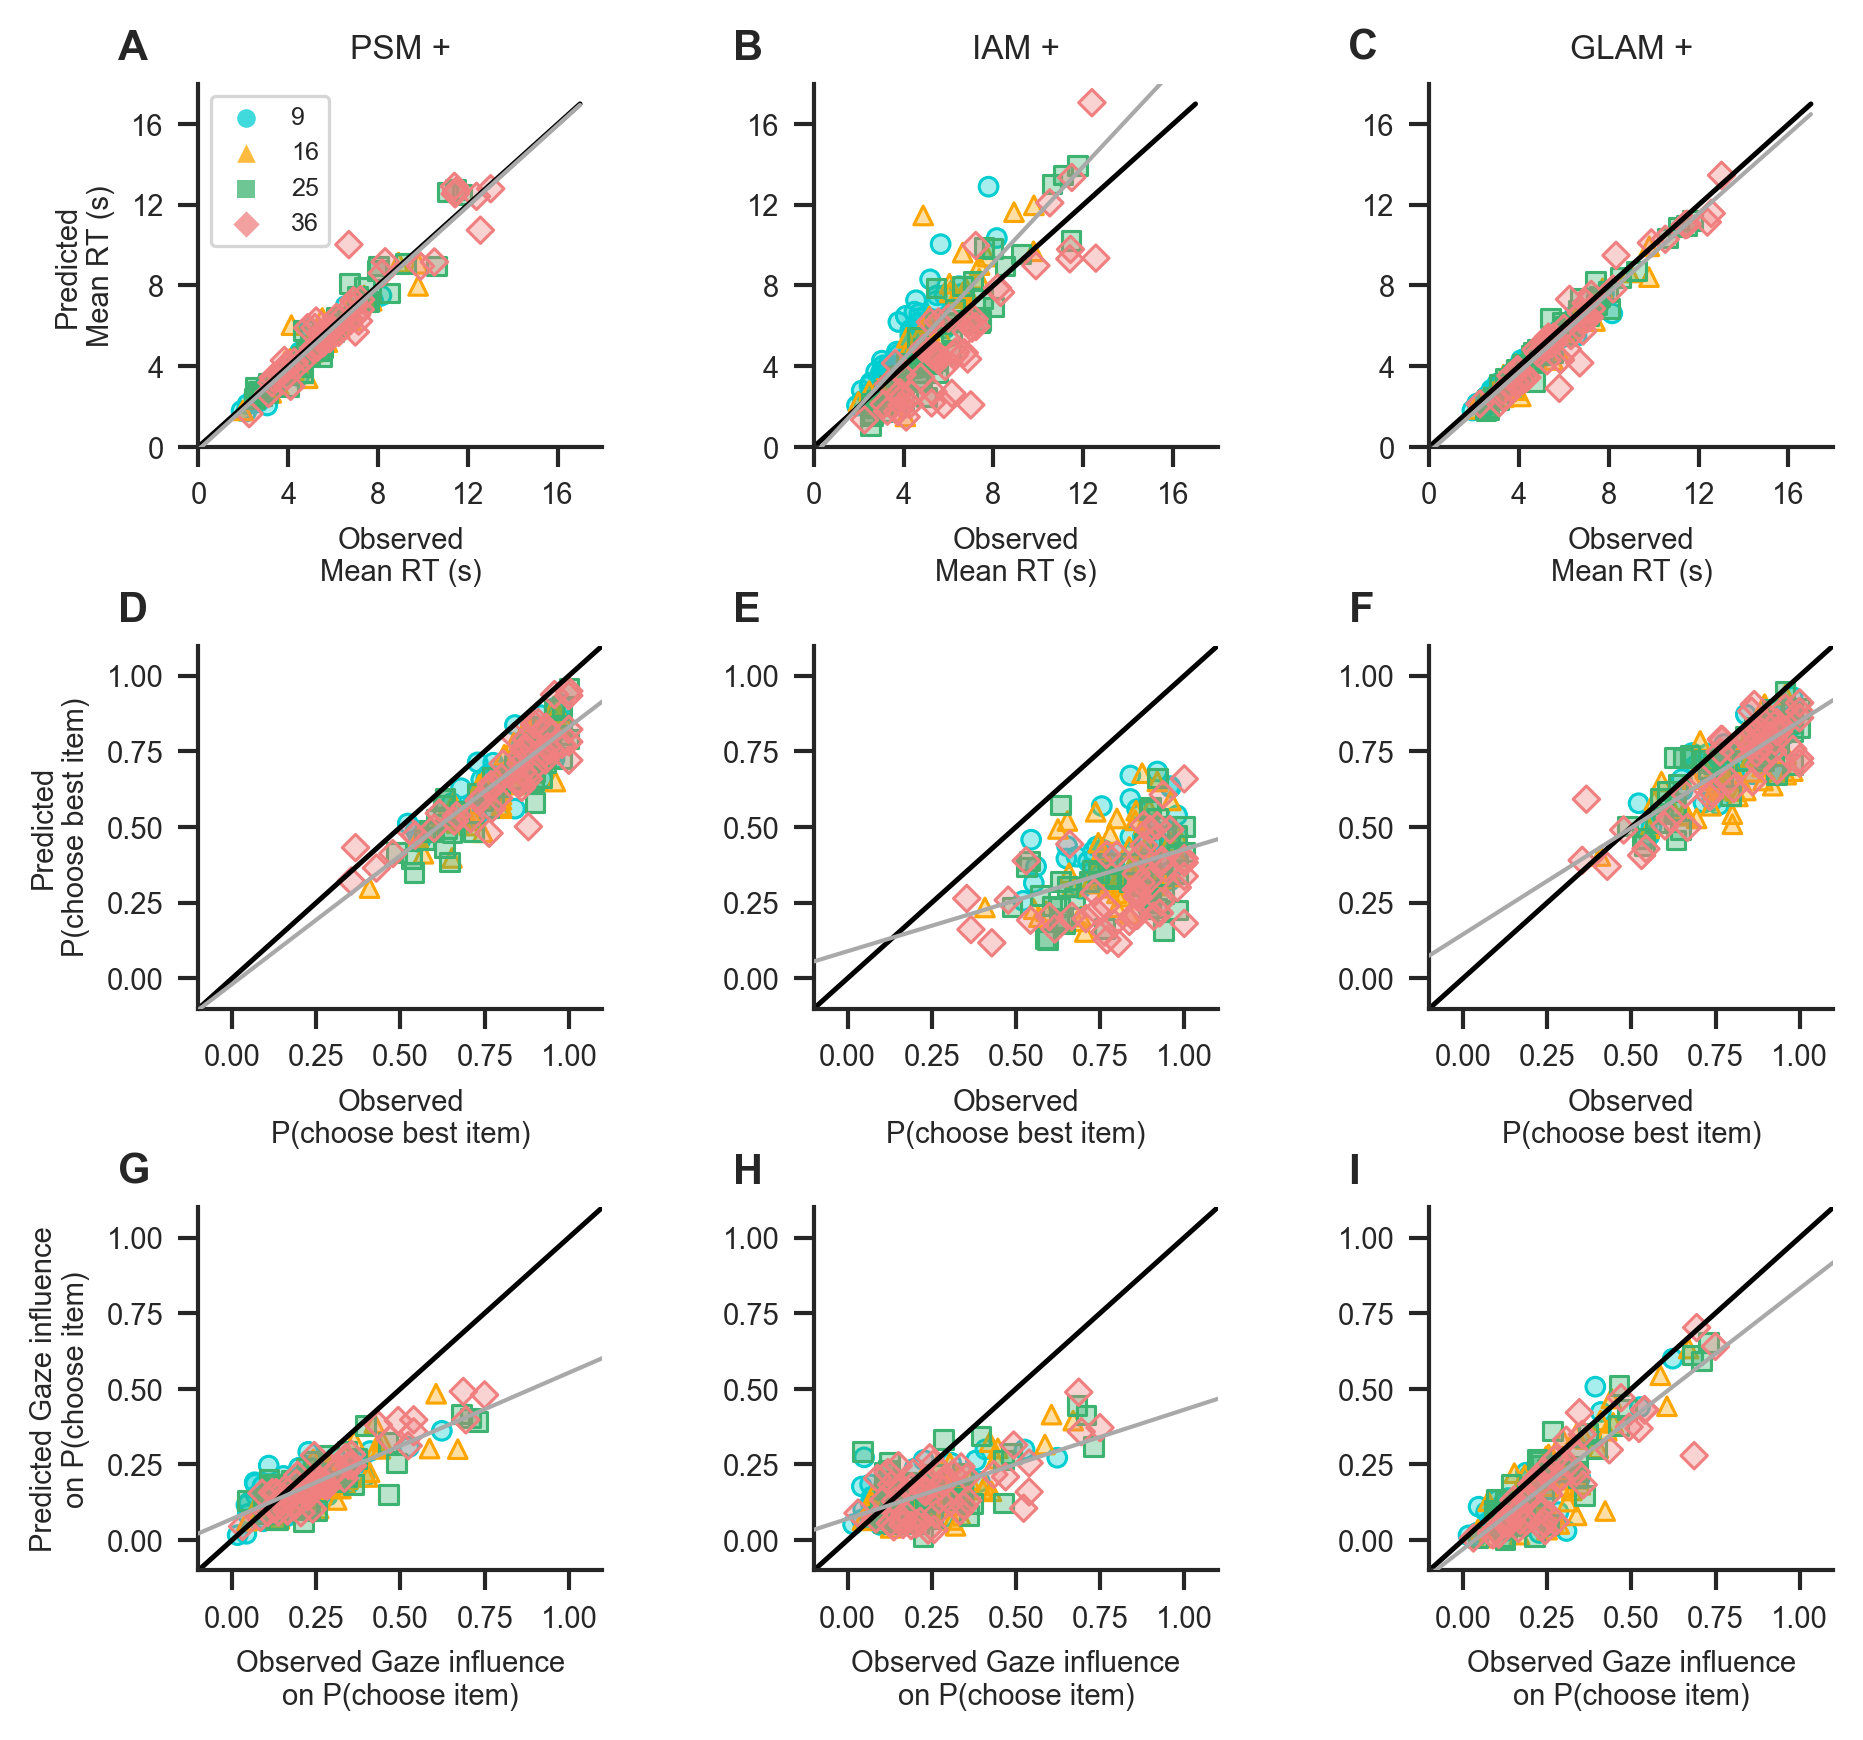

In [10]:
np.random.seed(2438)
seed = 2438

# only models with active gaze influence
gaze_bias = 'with_active_gaze'

# make fig
fig, axs = plt.subplots(3,3,figsize=cm2inch(16,15), dpi=300)

for model_i, (model_name, model_label) in enumerate(zip(
    ['probabilistic_satisficing', 'independent_accumulation', 'GLAM'],
    ['PSM +', 'IAM +', 'GLAM +'])):
    
    # add title
    axs[0,model_i].set_title(model_label, fontsize=8)
    print('\n\n----\n{}'.format(model_label))
    
    # get aggregate data
    mfx_data = get_aggregate_data('{}_{}'.format(model_name, gaze_bias))
    
    # iterate metrics
    for metric_i, metric in enumerate(['rt', 'p_choose_best', 'gaze_influence']):
        print('\n{}:'.format('-'.join(metric.split('_'))))
        
        
        # scatter
        for si, setsize in enumerate(setsizes):
            # subset
            mfx_data_setsize = mfx_data[mfx_data['setsize']==setsize].copy()            
            # scatter
            if 'rt' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 1000,
                                         mfx_data_setsize['pred_{}'.format(metric)].values / 1000,
                                                  marker=markers[si],
                                         ax=axs[metric_i,model_i],
                                         color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(0, 18)
                axs[metric_i,model_i].set_xlim(0, 18)
                axs[metric_i,model_i].set_xticks(np.array([0,4,8,12,16]))
                axs[metric_i,model_i].set_yticks(np.array([0,4,8,12,16]))
                axs[metric_i,model_i].set_xticklabels(np.array([0,4,8,12,16]), fontsize=7)
                axs[metric_i,model_i].set_yticklabels(np.array([0,4,8,12,16]), fontsize=7)
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nMean RT (s)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nMean RT (s)', fontsize=7)
            elif 'p_choose_best' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                 mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                 ax=axs[metric_i,model_i],
                                                 color=colors[si])
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nP(choose best item)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nP(choose best item)', fontsize=7)
            else:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                  mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                  ax=axs[metric_i,model_i],
                                                  color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted Gaze influence\non P(choose item)', fontsize=7)  
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed Gaze influence\non P(choose item)', fontsize=7)

                
        # mfx regression
        mfx_filename = '{}_observed-predicted_{}-{}_mfx'.format('-'.join(metric.split('_')),
                                                                '-'.join(model_name.split('_')),
                                                                '-'.join(gaze_bias.split('_')))
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            converged = False
            tries = 1
            while not converged:
                # make model
                samples = 2000
                burn = 500
                model = bambi.Model(data=mfx_data)
                model.add('pred_{} ~ obs_{}'.format(metric, metric),
                          random=['1+obs_{}|setsize'.format(metric)],
                          categorical=['setsize'])
                # sample posterior
                results = model.fit(samples=samples,
                                    tune=burn*tries,
                                    chains=2,
                                    backend='pymc',
                                    init='ADVI',
                                    n_init=50000,
                                    random_seed=seed)
                # save results
                pm.trace_to_dataframe(model.backend.trace).to_csv(
                    mfx_dir+mfx_filename+'_mtrace.csv', index=False)
                az.plot_trace(results)
                plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
                summary = az.summary(results, round_to='none')
                summary.to_csv(mfx_dir+mfx_filename+'.csv')
                # check convergence
                if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
                   (np.abs(summary.loc['obs_{}[0]'.format(metric), 'r_hat'] - 1) <= 0.05):
                    converged = True
                tries += 1
        else:
            print('Loading mfx-summary from '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
        b0,_ = get_var(summary, 'Intercept[0]')
        b1,_ = get_var(summary, 'obs_{}[0]'.format(metric))
        seed += 1
        # add regression line
        if 'rt' in metric:
            xs = np.linspace(0,17,100)
            axs[metric_i,model_i].plot(xs, (b0/1000)+(b1*xs), color='darkgray', lw=1, zorder=99)
        else:
            xs = np.linspace(-0.1,1.1,100)
            axs[metric_i,model_i].plot(xs, (b0/100)+(b1*xs), color='darkgray', lw=1, zorder=99)
        # add diagonal
        axs[metric_i,model_i].plot(xs, xs, color='k')
    

# add panel indicators
for ax, label in zip(axs.ravel(), list('ABCDEFGHIJKLMNOPQR')):
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.text(-0.2, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    despine(ax=ax)

# add legend
leg = axs[0,0].legend(loc='upper left', fontsize=6)
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)

# save
fig.tight_layout(h_pad=0, w_pad=3)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.pdf', dpi=300)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.png', dpi=300)
fig.savefig('figures/Figure-6_absolute-fit_gaze-bias-models.jpg', dpi=300)

## .. and for model variants with passive gaze



----
PSM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -220.336728537312, 94% HPD: -407.79823831433913, -2.379297781001517
obs_rt[0]; Mean: 0.9999091530190912, 94% HPD: 0.946325645664166, 1.0581083918989185

p-choose-best:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 9.871467113392944, 94% HPD: 4.859011747691453, 14.62057081270476
obs_p_choose_best[0]; Mean: 0.7546775342855224, 94% HPD: 0.6933244615611247, 0.8064937144009949

gaze-influence:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 7.242128848170488, 94% HPD: 4.715635173663054, 9.778383941297301
obs_gaze_influence[0]; Mean: 0.17949091120774952, 94% HPD: 0.06758959263384118, 0.2802127396137112


----
IAM +

rt:
Loading mfx-summary from results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -669.8000742606739, 94% HPD: -1998.0974719466892, 561.5724631400096
obs_rt[0]; Mean: 1

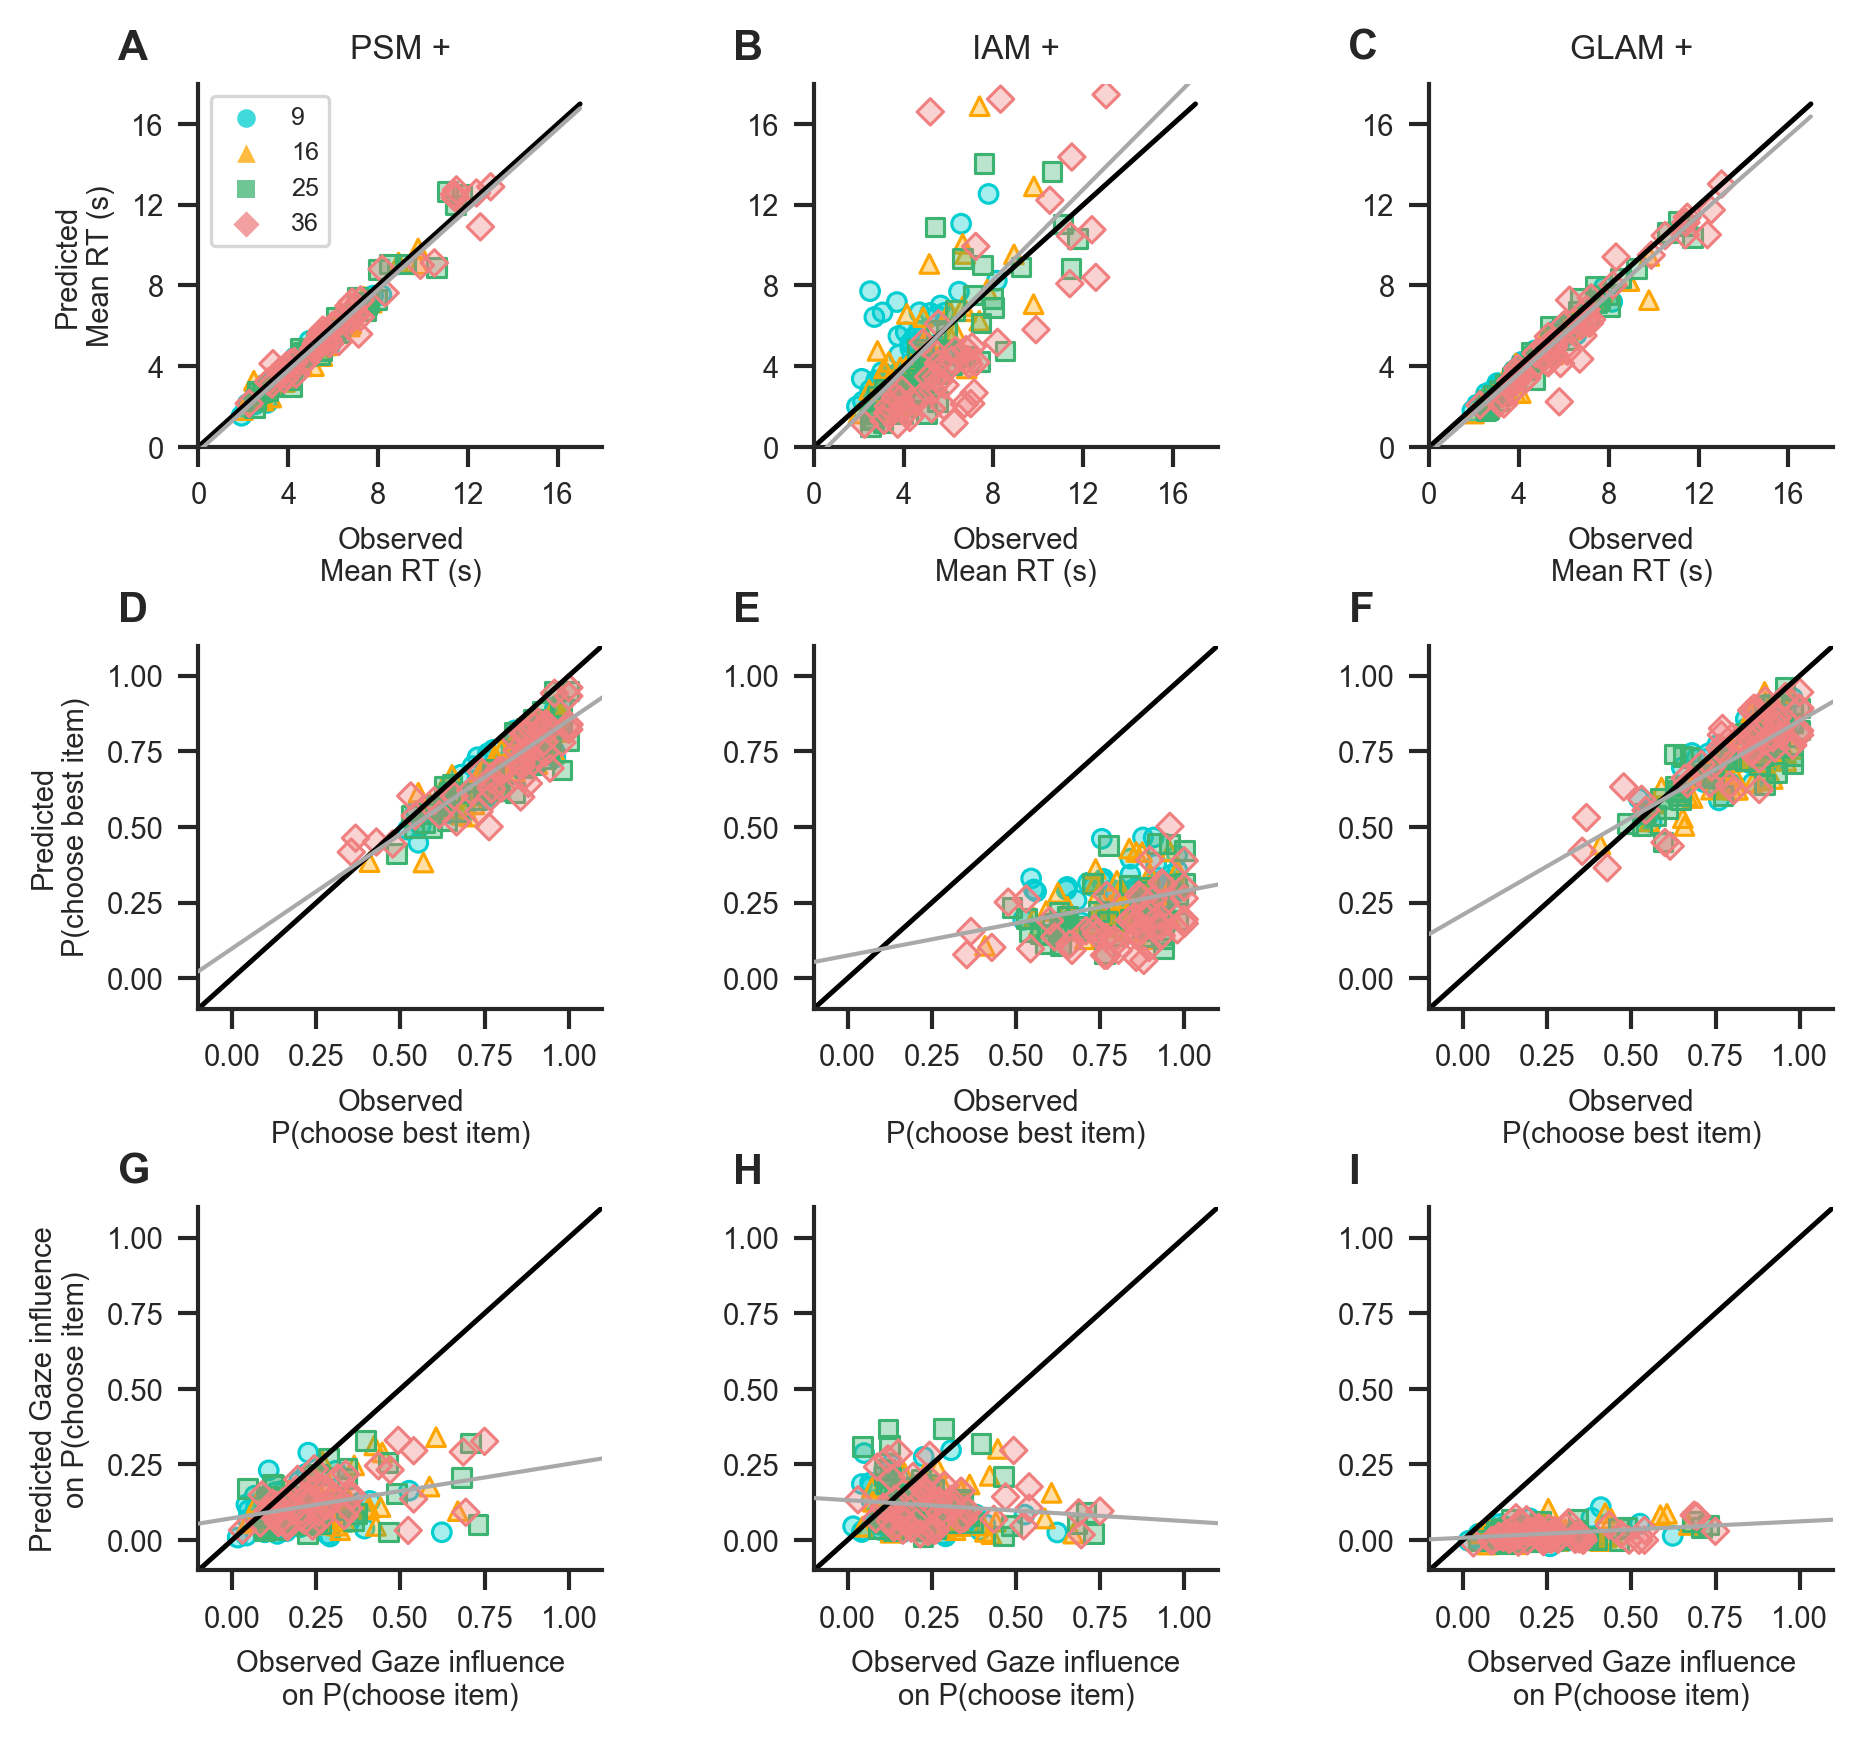

In [11]:
np.random.seed(2438)
seed = 2438

# only models with passive gaze
gaze_bias = 'with_passive_gaze'

# make fig
fig, axs = plt.subplots(3,3,figsize=cm2inch(16,15), dpi=300)

for model_i, (model_name, model_label) in enumerate(zip(
    ['probabilistic_satisficing', 'independent_accumulation', 'GLAM'],
    ['PSM +', 'IAM +', 'GLAM +'])):
    
    # add title
    axs[0,model_i].set_title(model_label, fontsize=8)
    print('\n\n----\n{}'.format(model_label))
    
    # get aggregate data
    mfx_data = get_aggregate_data('{}_{}'.format(model_name, gaze_bias))
    
    # iterate metrics
    for metric_i, metric in enumerate(['rt', 'p_choose_best', 'gaze_influence']):
        print('\n{}:'.format('-'.join(metric.split('_'))))
        
        
        # scatter
        for si, setsize in enumerate(setsizes):
            # subset
            mfx_data_setsize = mfx_data[mfx_data['setsize']==setsize].copy()            
            # scatter
            if 'rt' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 1000,
                                         mfx_data_setsize['pred_{}'.format(metric)].values / 1000,
                                                  marker=markers[si],
                                         ax=axs[metric_i,model_i],
                                         color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(0, 18)
                axs[metric_i,model_i].set_xlim(0, 18)
                axs[metric_i,model_i].set_xticks(np.array([0,4,8,12,16]))
                axs[metric_i,model_i].set_yticks(np.array([0,4,8,12,16]))
                axs[metric_i,model_i].set_xticklabels(np.array([0,4,8,12,16]), fontsize=7)
                axs[metric_i,model_i].set_yticklabels(np.array([0,4,8,12,16]), fontsize=7)
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nMean RT (s)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nMean RT (s)', fontsize=7)
            elif 'p_choose_best' in metric:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                 mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                 ax=axs[metric_i,model_i],
                                                 color=colors[si])
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted\nP(choose best item)', fontsize=7)
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed\nP(choose best item)', fontsize=7)
            else:
                axs[metric_i,model_i] =  _scatter(mfx_data_setsize['obs_{}'.format(metric)].values / 100,
                                                  mfx_data_setsize['pred_{}'.format(metric)].values / 100,
                                                  marker=markers[si],
                                                  ax=axs[metric_i,model_i],
                                                  color=colors[si], label=setsize)
                axs[metric_i,model_i].set_ylim(-0.1, 1.1)
                axs[metric_i,model_i].set_xlim(-0.1, 1.1)
                axs[metric_i,model_i].set_xticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                axs[metric_i,model_i].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1]))
                if model_i == 0:
                    axs[metric_i,model_i].set_ylabel('Predicted Gaze influence\non P(choose item)', fontsize=7)  
                else:
                    axs[metric_i,model_i].set_ylabel('', fontsize=7)
                axs[metric_i,model_i].set_xlabel('Observed Gaze influence\non P(choose item)', fontsize=7)

                
        # mfx regression
        mfx_filename = '{}_observed-predicted_{}-{}_mfx'.format('-'.join(metric.split('_')),
                                                                '-'.join(model_name.split('_')),
                                                                '-'.join(gaze_bias.split('_')))
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
            converged = False
            tries = 1
            while not converged:
                # make model
                samples = 2000
                burn = 500
                model = bambi.Model(data=mfx_data)
                model.add('pred_{} ~ obs_{}'.format(metric, metric),
                          random=['1+obs_{}|setsize'.format(metric)],
                          categorical=['setsize'])
                # sample posterior
                results = model.fit(samples=samples,
                                    tune=burn*tries,
                                    chains=2,
                                    backend='pymc',
                                    init='ADVI',
                                    n_init=50000,
                                    random_seed=seed)
                # save results
                pm.trace_to_dataframe(model.backend.trace).to_csv(
                    mfx_dir+mfx_filename+'_mtrace.csv', index=False)
                az.plot_trace(results)
                plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
                summary = az.summary(results, round_to='none')
                summary.to_csv(mfx_dir+mfx_filename+'.csv')
                # check convergence
                if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
                   (np.abs(summary.loc['obs_{}[0]'.format(metric), 'r_hat'] - 1) <= 0.05):
                    converged = True
                tries += 1
        else:
            print('Loading mfx-summary from '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
        b0,_ = get_var(summary, 'Intercept[0]')
        b1,_ = get_var(summary, 'obs_{}[0]'.format(metric))
        seed += 1
        # add regression line
        if 'rt' in metric:
            xs = np.linspace(0,17,100)
            axs[metric_i,model_i].plot(xs, (b0/1000)+(b1*xs), color='darkgray', lw=1, zorder=99)
        else:
            xs = np.linspace(-0.1,1.1,100)
            axs[metric_i,model_i].plot(xs, (b0/100)+(b1*xs), color='darkgray', lw=1, zorder=99)
        # add diagonal
        axs[metric_i,model_i].plot(xs, xs, color='k')
    

# add panel indicators
for ax, label in zip(axs.ravel(), list('ABCDEFGHIJKLMNOPQR')):
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.text(-0.2, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    despine(ax=ax)

# add legend
leg = axs[0,0].legend(loc='upper left', fontsize=6)
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)

# save
fig.tight_layout(h_pad=0, w_pad=3)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.pdf', dpi=300)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.png', dpi=300)
fig.savefig('figures/Figure-6-figure-supplement-1_absolute-fit_passive-gaze-models.jpg', dpi=300)